## Pytorch code percolation model with Ohtsuki CNN

## initializations

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
seed=42
import torch
torch.manual_seed(seed)
import numpy as np
np.random.seed(seed+1)

In [3]:
from __future__ import print_function, division
import os
print('torch version:',torch.__version__)
import sklearn
print('sklearn version:', sklearn.__version__)

torch version: 1.3.1
sklearn version: 0.22.1


In [4]:
import torchvision
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import numpy as np
import time
import os
import copy

In [5]:
t=torch.Tensor()
print(t.dtype)
print(t.device)
print(t.layout)

torch.float32
cpu
torch.strided


Now we switch to the GPU

In [6]:
device=t.device

In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
print(device)


cuda:0


## starting the main code

In [8]:
img_sizeX= 100
img_sizeY= 100 #img_sizeX
validation_split= 0.1

In [9]:
class MyImageFolder2(torchvision.datasets.ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(MyImageFolder2, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path 

In [10]:
training_set=0
validation_set=0
dataname='L200'
path='../'+dataname
transform=torchvision.transforms.ToTensor()

whole_dataset=MyImageFolder2(root=path,
                                                   transform=transform)


In [11]:
data_size = len(whole_dataset)
validation_split=0.1
split=int(np.floor(validation_split*data_size))
training=int(data_size-split)
#split the data into training and validation
training_set, validation_set= torch.utils.data.random_split(whole_dataset,(training,split))
#Load data into batches 
train=torch.utils.data.DataLoader(training_set,batch_size=16,
                                          shuffle=True)

val=torch.utils.data.DataLoader(validation_set,batch_size=16 )

In [12]:
class_names =whole_dataset.classes
class_names

['p0.1',
 'p0.2',
 'p0.3',
 'p0.4',
 'p0.5',
 'p0.55',
 'p0.56',
 'p0.57',
 'p0.58',
 'p0.59',
 'p0.5927',
 'p0.6',
 'p0.61',
 'p0.62',
 'p0.63',
 'p0.64',
 'p0.65',
 'p0.7',
 'p0.8',
 'p0.9']

In [13]:
inputs,labels,paths= next(iter(val))

In [14]:
def imshow(inp, title=None):
    # torch convention gives [channel, height,width] but imshow gives [height,width,channel] hence the transpose
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure()
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause a bit so that plots are updated



In [15]:
img_sizeX,img_sizeY= inputs.shape[-1],inputs.shape[-2]
img_sizeY

102

In [16]:
labels.shape

torch.Size([16])

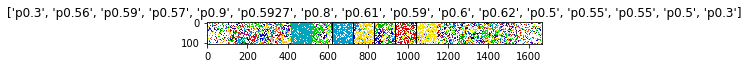

In [17]:
# Now we construct a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=16)
#We plot all the images in one batch (here 16 images)
imshow(out, title=[class_names[x] for x in labels])


In [18]:
paths#batch size, channels, height, width

('../L200/p0.3/pc_0__p0.3_L200_s331_.png',
 '../L200/p0.56/pc_0__p0.56_L200_s257_.png',
 '../L200/p0.59/pc_0__p0.59_L200_s423_.png',
 '../L200/p0.57/pc_0__p0.57_L200_s912_.png',
 '../L200/p0.9/pc_1__p0.9_L200_s396_top_{0.5}_side_{0.5}_size_max_clus36012.png',
 '../L200/p0.5927/pc_1__p0.5927_L200_s946_top_{0.5286080273270709}_side_set()_size_max_clus4694.png',
 '../L200/p0.8/pc_1__p0.8_L200_s574_top_{0.32727272727272727}_side_{0.32727272727272727}_size_max_clus31868.png',
 '../L200/p0.61/pc_1__p0.61_L200_s306_top_{0.7378947368421053}_side_{0.7378947368421053}_size_max_clus17098.png',
 '../L200/p0.59/pc_0__p0.59_L200_s61_.png',
 '../L200/p0.6/pc_1__p0.6_L200_s987_top_{0.8910540301151462}_side_{0.8910540301151462}_size_max_clus15886.png',
 '../L200/p0.62/pc_1__p0.62_L200_s61_top_{0.7213740458015268}_side_{0.7213740458015268}_size_max_clus22370.png',
 '../L200/p0.5/pc_0__p0.5_L200_s144_.png',
 '../L200/p0.55/pc_0__p0.55_L200_s974_.png',
 '../L200/p0.55/pc_0__p0.55_L200_s174_.png',
 '../L20

In [19]:
inputs

tensor([[[[0.0000, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.4392,  ..., 0.9608, 0.9843, 0.9843],
          ...,
          [1.0000, 1.0000, 0.7333,  ..., 1.0000, 0.0000, 1.0000],
          [1.0000, 0.0000, 1.0000,  ..., 1.0000, 1.0000, 0.4824],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[0.5922, 1.0000, 0.8431,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.0000,  ..., 0.8745, 0.0000, 0.0000],
          ...,
          [1.0000, 1.0000, 0.9961,  ..., 1.0000, 0.6431, 1.0000],
          [1.0000, 0.6118, 1.0000,  ..., 1.0000, 1.0000, 0.0000],
          [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]],

         [[0.8667, 0.0000, 0.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 0.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
          [1.0000, 1.0000, 0.4980,  ..., 0

In [20]:
batch_size=16
num_of_train_samples = len(training_set) # total training samples
num_of_test_samples = len(validation_set) #total validation samples
steps_per_epoch = np.ceil(num_of_train_samples // batch_size)
number_classes = len(class_names)
print(num_of_train_samples)
print(num_of_test_samples )
print(len(train)) 
print(len(val))
print(number_classes )

18000
2000
1125
125
20


## building the CNN

In [21]:
class Network(nn.Module):   
    def __init__(self):
        super(Network, self).__init__()
        # Defining a 2D convolution layer
        self.conv1=nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0, bias=False)
        self.conv2=nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=1, bias=False)
       
            
        # Defining another 2D convolution layer
        self.conv3=nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=0, bias=False)
        self.conv4=nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1, bias=False)
            
            
        self.conv5=nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=0, bias=False)
        self.conv6=nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
                  
        self.fc1=nn.Linear(in_features=6400, out_features=64,bias=False) 
        self.fc2=nn.Linear(in_features=64,out_features=number_classes,bias=False)
        

    # Defining the forward pass    
    def forward(self, x):
        x = self.conv1(x)
        x=F.relu(x)
        x = self.conv2(x)
        x=F.relu(x)
        x=F.max_pool2d(x,kernel_size=2, stride=2)
        x=F.dropout(x,p=0.5)
        
        
        
        x = self.conv3(x)
        x=F.relu(x)
        x = self.conv4(x)
        x=F.relu(x)
        x=F.max_pool2d(x,kernel_size=2, stride=2)
        x=F.dropout(x,p=0.5)
        
        
        
        x = self.conv5(x)
        x=F.relu(x)
        x = self.conv6(x)
        x=F.relu(x)
        x=F.max_pool2d(x,kernel_size=2, stride=2)
        x=F.dropout(x,p=0.5)
        
        #Beginning of dense layers
        x = x.view(x.size(0), -1) #flatten the network
        x=self.fc1(x)
        x=self.fc2(x)    
        
    
        return x

In [22]:
model=Network()
# defining the optimizer

optimizer=torch.optim.Adadelta(model.parameters(), lr=1.0, rho=0.9, eps=1e-06, weight_decay=0)
# defining the loss function
criterion = nn.CrossEntropyLoss()

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)


Network(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (conv2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), bias=False)
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), bias=False)
  (conv6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (fc1): Linear(in_features=6400, out_features=64, bias=False)
  (fc2): Linear(in_features=64, out_features=20, bias=False)
)


In [23]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
conv1.weight 	 torch.Size([16, 3, 5, 5])
conv2.weight 	 torch.Size([16, 16, 5, 5])
conv3.weight 	 torch.Size([32, 16, 3, 3])
conv4.weight 	 torch.Size([32, 32, 3, 3])
conv5.weight 	 torch.Size([64, 32, 3, 3])
conv6.weight 	 torch.Size([64, 64, 3, 3])
fc1.weight 	 torch.Size([64, 6400])
fc2.weight 	 torch.Size([20, 64])
Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 1.0, 'rho': 0.9, 'eps': 1e-06, 'weight_decay': 0, 'initial_lr': 1.0, 'params': [140654144192176, 140654141450992, 140654141461840, 140654141438304, 140654141414928, 140654177917760, 140654141425936, 140654141424896]}]


In [24]:
for param in model.parameters():
    print(param.shape)

torch.Size([16, 3, 5, 5])
torch.Size([16, 16, 5, 5])
torch.Size([32, 16, 3, 3])
torch.Size([32, 32, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([64, 64, 3, 3])
torch.Size([64, 6400])
torch.Size([20, 64])


In [25]:
#the model is sent to the GPU
model = model.to(device)


In [26]:
def train_model(model,criterion, optimizer, num_epochs, scheduler, batch_size):
    since=time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    

    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch,num_epochs-1))
        print('-' * 10)
        
    #two phases training and validating
        for phase in [train,val]:
            if phase == train:
                model.train()# set the model to training mode
            else:
                model.eval() 
                
            running_loss=0.0
            running_corrects=0.0
            
            # Here's where the training happens
            print('Iterating through data...')
            
            for i, (inputs,labels,paths) in enumerate(phase):
                inputs=inputs.to(device)
                labels=labels.to(device)
                #paths=paths.to(device)
                
                
                #put the gradient to zero to avoid accumulation during back propagation
                optimizer.zero_grad()
                
                
                #now we need to carry out the forward and backward process in different steps
                #First the forward training
                #for the training step we need to log the loss
                with torch.set_grad_enabled(phase==train):
                    outputs=model(inputs)
                    _, preds= torch.max(outputs,1)
                    loss=criterion(outputs,labels)
                
                #still for the training phase we need to implement backword process and optimization
                
                    if phase==train:
                        loss.backward()
                        optimizer.step()
                        
                # We want variables to hold the loss statistics
                #loss.item() extract the loss value as float then it is multiply by the batch size
                running_loss+=loss.item()*inputs.size(0)
                running_corrects+= torch.sum(preds==labels.data)
                
            if phase == train:
                scheduler.step()

                
            
            if phase ==train:
                epoch_loss= running_loss/len(phase.dataset)
                epoch_acc = running_corrects.double()/ len(phase.dataset)
                print('{} loss: {:4f} accuracy: {:4f}'.format(
                'training', epoch_loss, epoch_acc
            ))
                
            
            if phase==val:
                epoch_loss= running_loss/len(val.dataset)
                epoch_acc = running_corrects.double()/len(val.dataset)
                print('{} val_loss: {:4f} val_accuracy: {:4f}'.format(
            'validation:', epoch_loss, epoch_acc
            ))
            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == val and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

                    
        

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs,labels,paths) in enumerate(val):
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            

            outputs = model(inputs) #value of the output neurons
            _, preds = torch.max(outputs, 1) #gives the max value and stores in preds the neurons to which it belongs

            for j in range(inputs.size()[0]):
                images_handeled += 1
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('predicted: {}; \n true label {}; \n path: {};'.format(class_names[preds[j]] ,
                                                                     class_names[labels[j]],paths[j])
                            )
                imshow(inputs.cpu().data[j])
                
                
                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)



In [28]:
def visualize_model_misclassified(model, num_images=6): #gives shows only the misclassified images
    import re
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs,labels,paths) in enumerate(val):
            inputs=inputs.to(device)
            labels=labels.to(device)
            
            
            outputs = model(inputs) #value of the output neurons
            _, preds = torch.max(outputs, 1) #gives the max value and stores in preds the neurons to which it belongs

            for j in range(inputs.size()[0]):
                if labels[j]!=preds[j] and abs(labels[j]-preds[j])>4:
                #print(inputs.size()[0])
                    images_so_far += 1
                    ax = plt.subplot(num_images//2, 2, images_so_far)
                    ax.axis('off')
                    ax.set_title('predicted: {}; \n true label {}; \n path: {};'.format(class_names[preds[j]] ,
                                                                     class_names[labels[j]],paths[j])
                            )
                    imshow(inputs.cpu().data[j])
                
                
                    if images_so_far == num_images:
                        model.train(mode=was_training)
                        return
        
        #print(misclassified, 'images misclassified')
        model.train(mode=was_training)

In [29]:
num_epochs=10
base_model = train_model(model, criterion, optimizer,num_epochs,exp_lr_scheduler,batch_size=16 )


Epoch 0/9
----------
Iterating through data...
training loss: 2.626981 accuracy: 0.121333
Iterating through data...
validation: val_loss: 2.366075 val_accuracy: 0.142500

Epoch 1/9
----------
Iterating through data...
training loss: 1.716034 accuracy: 0.326611
Iterating through data...
validation: val_loss: 1.416202 val_accuracy: 0.452500

Epoch 2/9
----------
Iterating through data...
training loss: 1.352249 accuracy: 0.449556
Iterating through data...
validation: val_loss: 1.059515 val_accuracy: 0.570000

Epoch 3/9
----------
Iterating through data...
training loss: 1.167451 accuracy: 0.512222
Iterating through data...
validation: val_loss: 1.242344 val_accuracy: 0.459500

Epoch 4/9
----------
Iterating through data...
training loss: 1.046227 accuracy: 0.560944
Iterating through data...
validation: val_loss: 0.946868 val_accuracy: 0.601000

Epoch 5/9
----------
Iterating through data...
training loss: 0.983699 accuracy: 0.582722
Iterating through data...
validation: val_loss: 0.84201

In [30]:
#save the model
PATH = './perco_density_'+dataname+'_OhtsukiCNN_L200'+'.pth'
torch.save(model.state_dict(), PATH)

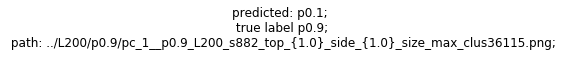

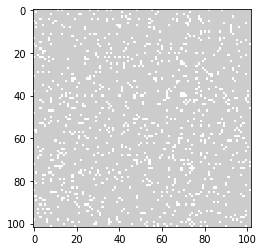

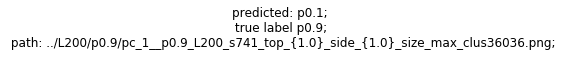

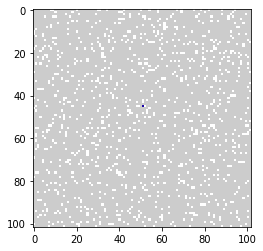

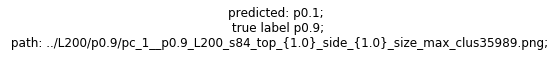

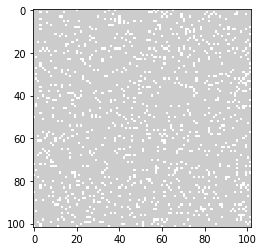

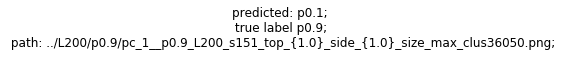

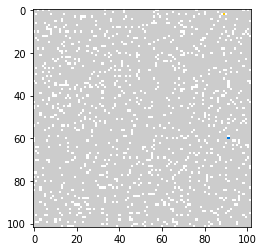

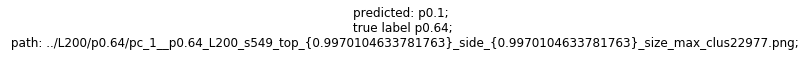

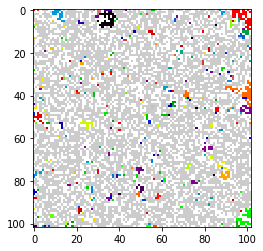

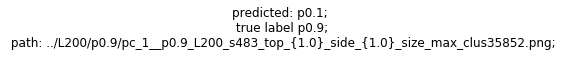

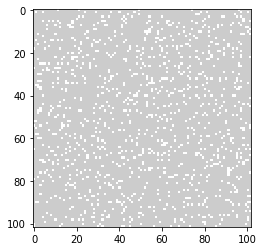

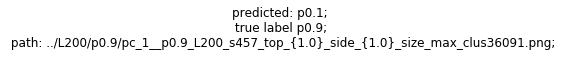

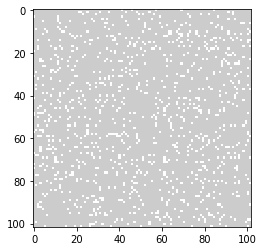

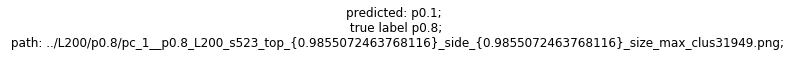

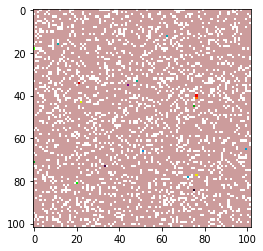

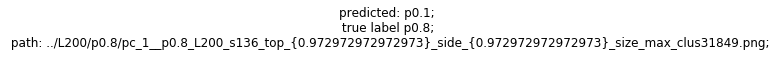

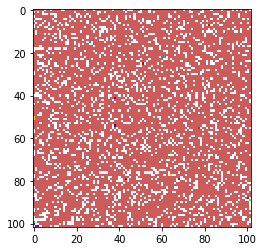

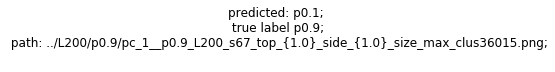

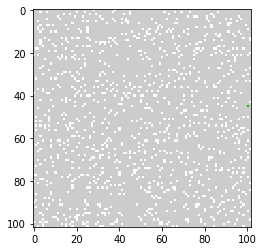

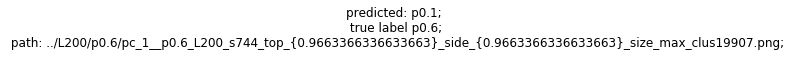

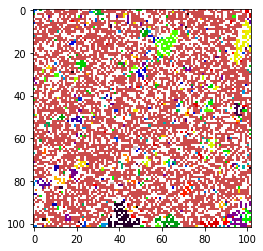

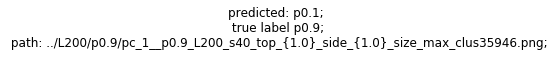

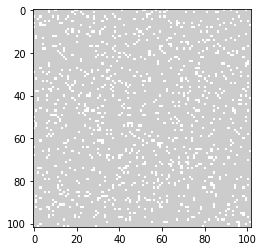

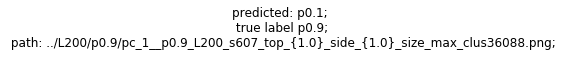

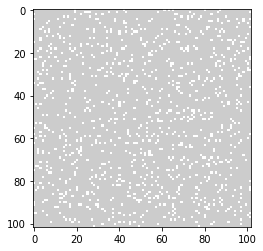

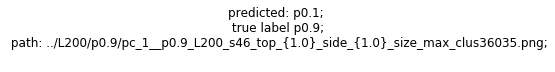

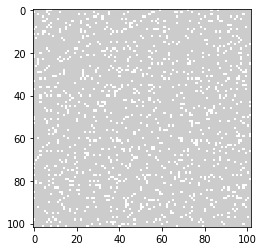

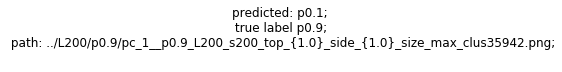

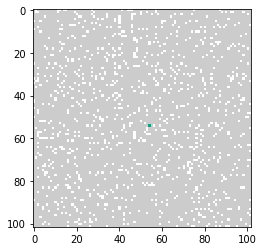

In [31]:
visualize_model_misclassified(model, num_images=30)

## testing the quality of the learned model

In [32]:
@torch.no_grad()
def simple_confusion_matrix(model,loader):
    confusion_matrix = torch.zeros(number_classes, number_classes)
    for i, (data) in enumerate(loader):
        inputs=data[0]
        labels=data[1]
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1) 
        for t, p in zip(labels.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1
                

    return confusion_matrix

In [33]:
cm=simple_confusion_matrix(model,val)
cm

tensor([[111.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0., 114.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   1.,  92.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   1., 112.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  81.,  15.,   1.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.,  19.,  64.,  23.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0., 

In [34]:
def confusion_matrix_torch(cm, target_names,cmap=None,title='Confusion Matrix'):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    #accuracy = np.trace(cm) / float(np.sum(cm))
    #misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(25, 25))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=40)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45, fontsize=30)
        plt.yticks(tick_marks, target_names,fontsize=30)

            
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j]),
                    ha="center", va="center",
                    color="white" if  cm[i, j] == 0 or cm[i, j] > thresh else "black") 


    plt.tight_layout()
    plt.ylabel('True label',fontsize=40)
    plt.xlabel('Predicted label',fontsize=40)
    plt.show()

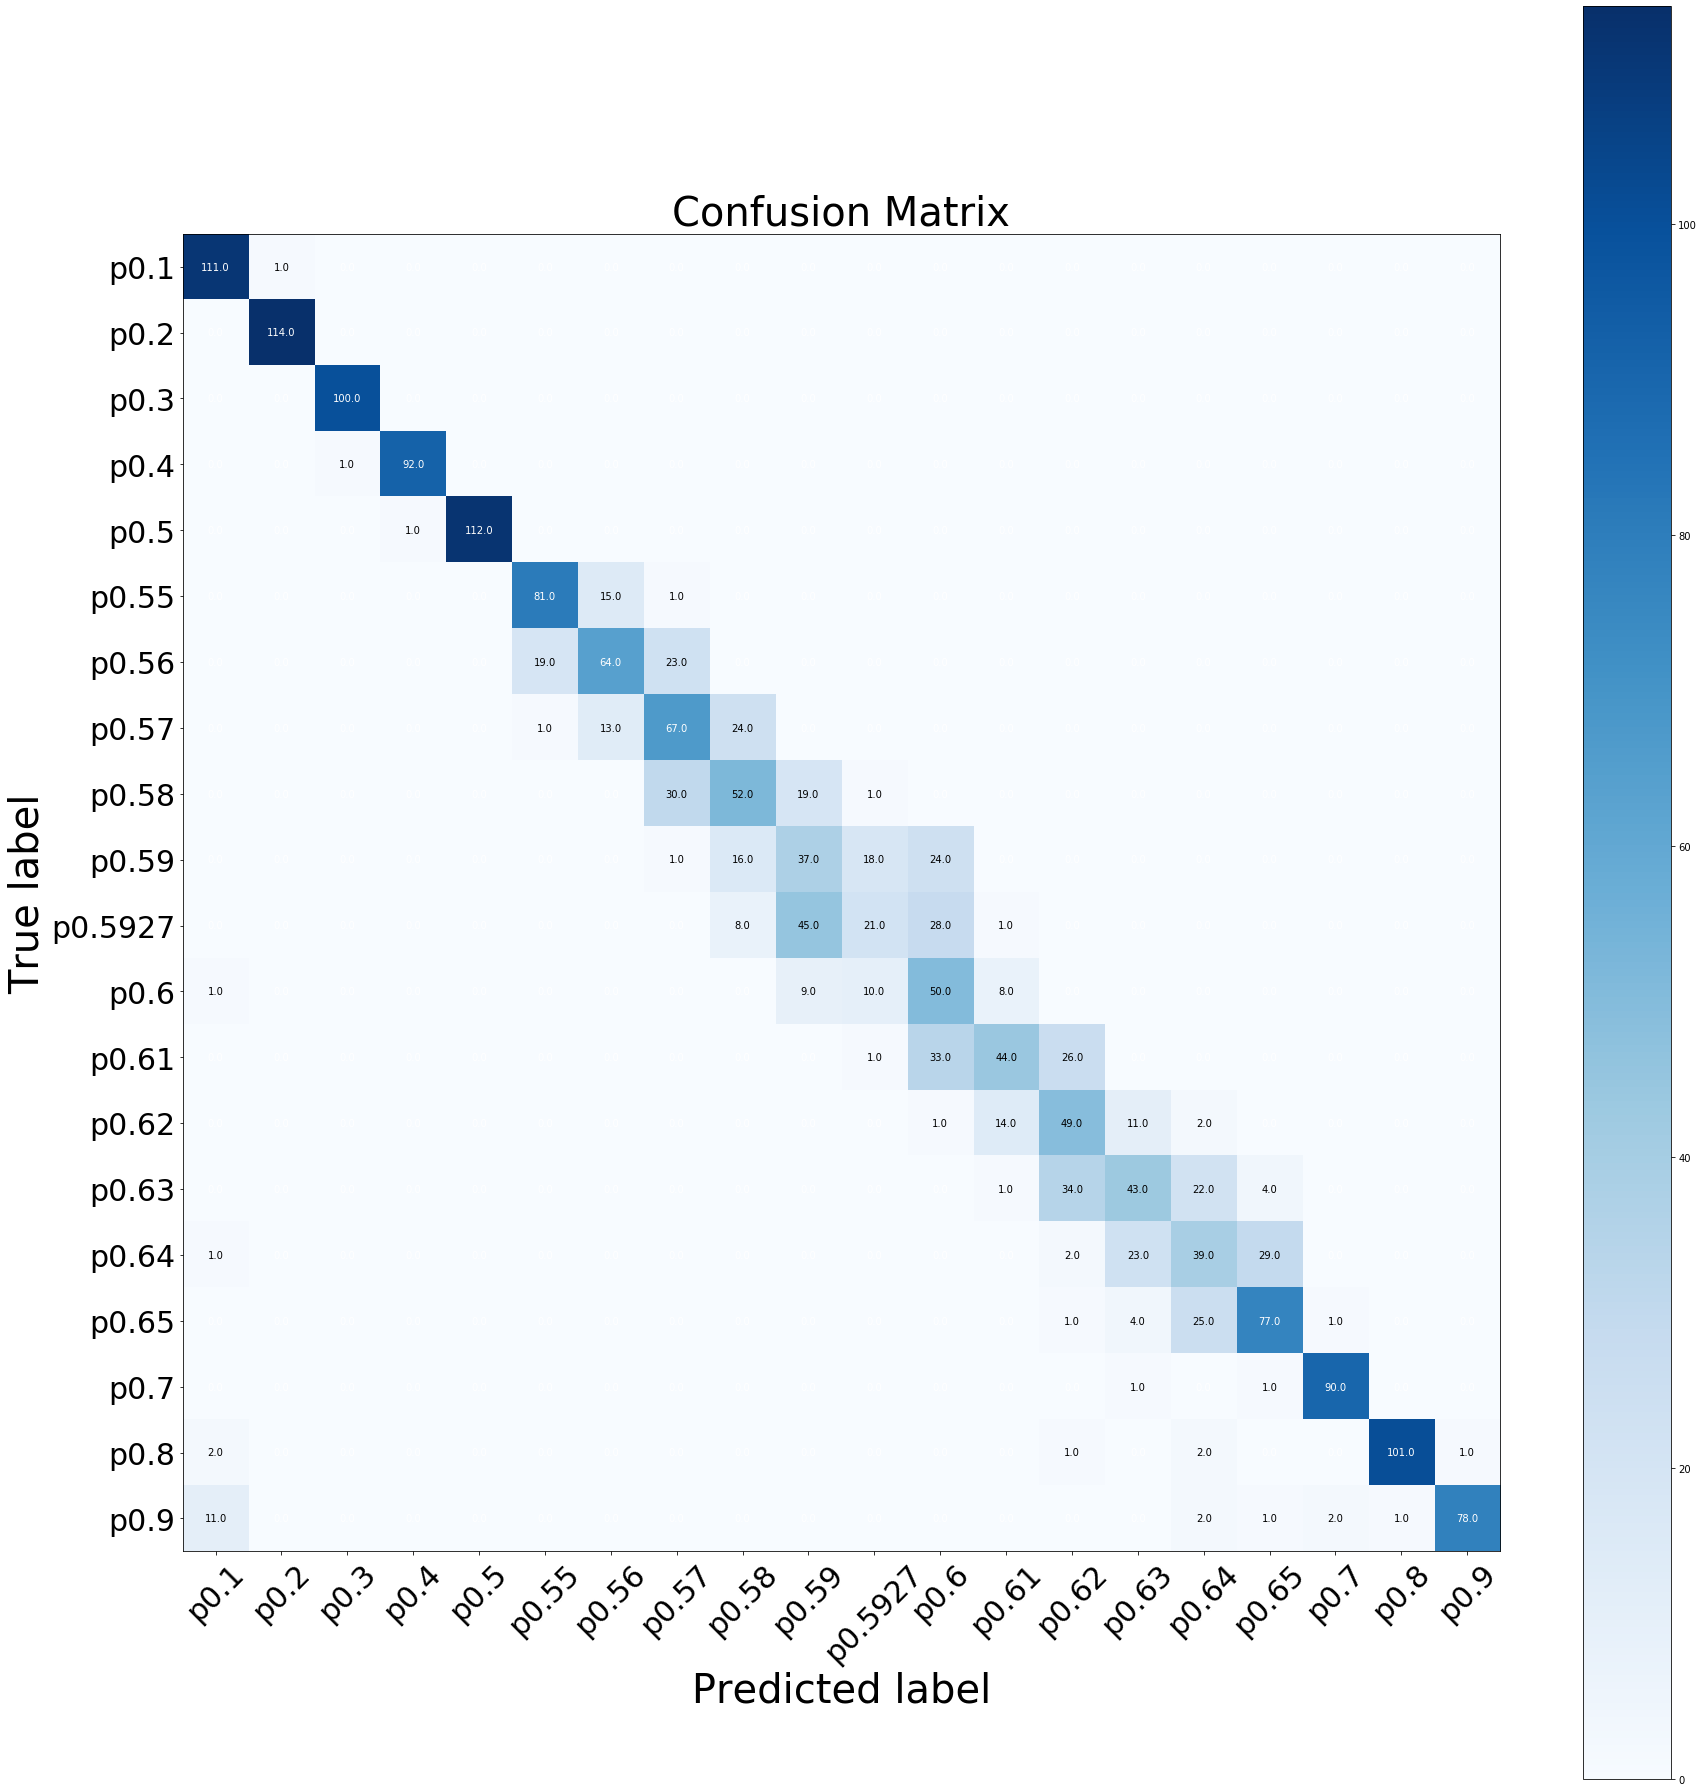

In [35]:
confusion_matrix_torch(cm,class_names)